In [1]:
import pandas as pd
import numpy as np
import os
# %pip install haversine
from haversine import haversine, Unit
from math import radians, degrees, sin, cos, atan2
from scipy.spatial.distance import cdist

## Read in the dataset that contains IFF with runway data

In [2]:
# Read IFF
chunked_iff_paths = ['Sherlock_data/chunked_IFF/' + file for file in os.listdir('Sherlock_data/chunked_IFF') if file.startswith('IFF_TOD') and file.endswith('csv')]
chunked_iffs = []
for path in chunked_iff_paths:
    df = pd.read_csv(path)
    sig_5 = df['significance']
    chunked_iffs.append(df)

In [3]:
iff_df = pd.concat(chunked_iffs)
# Renaming to seconds since midnight 1/1/70
iff_df = iff_df.drop('Unnamed: 0', axis=1)

In [4]:
iff_df.columns

Index(['fltKey', 'AcId', 'acType', 'Orig', 'Dest', 'perfCat', 'pKey_fltAcMode',
       'coord1', 'coord2', 'alt', 'significance', 'coord1Accur', 'coord2Accur',
       'groundSpeed', 'course', 'rateOfClimb', 'scratchPad', 'airportCode',
       'trackNumber', 'recTime', 'mergeKey', 'valid', 'datetime', 'lon', 'lat',
       'elevation', 'tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti', 'mslp',
       'vsby', 'gust', 'LNDRwy'],
      dtype='object')

In [5]:
# Filter out some columns for calculations
calc_df = iff_df[['mergeKey', 'AcId', 'acType', 'coord1', 'coord1Accur', 'coord2', 'coord2Accur', 'alt', 'significance', 'groundSpeed', 'datetime', 'LNDRwy']]
calc_df.head()

,mergeKey,AcId,acType,coord1,coord1Accur,coord2,coord2Accur,alt,significance,groundSpeed,datetime,LNDRwy
0,36838_10/01/2022,AAL1085,A321,33.94176,0.5,-118.33958,0.5,963.0,4,155.0,2022-10-01 17:46:57,25L
1,36838_10/01/2022,AAL1085,A321,33.94149,0.5,-118.34041,0.5,944.0,4,154.0,2022-10-01 17:46:58,25L
2,36838_10/01/2022,AAL1085,A321,33.94073,0.5,-118.34876,0.5,788.0,5,156.0,2022-10-01 17:47:08,25L
3,36838_10/01/2022,AAL1085,A321,33.93866,0.5,-118.36899,0.5,469.0,4,162.0,2022-10-01 17:47:32,25L
4,36838_10/01/2022,AAL1085,A321,33.93551,0.1,-118.40057,0.1,75.0,1,92.0,2022-10-01 17:48:13,25L


In [6]:
calc_df['alt'].describe()

count    120967.000000
mean        877.194929
std         775.720981
min           0.000000
25%         106.000000
50%         744.000000
75%        1469.000000
max       10000.000000
Name: alt, dtype: float64

In [7]:
calc_df[['coord1Accur', 'coord2Accur']].value_counts()

coord1Accur  coord2Accur
0.5          0.5            73940
0.1          0.1            47027
dtype: int64

## Read in the lookup table and merge necessary runway information into calc_df
Note: Bearing in the lookup table is in magnetic north and needs to be converted to true north

In [8]:
# Read lookup table into 
lookup = pd.read_csv('Sherlock_data/Lookup_table.csv')
lookup

,LNDRwy,Elevation,Threshold,Bearing,Descent_Points,Lat,Long
0,06L,128,"(33.949146, -118.430882)",71,"[('ALISN', 5.1, 1800), ('NATHN', 11, 3600)]",33.949146,-118.430882
1,06R,128,"(33.947037, -118.432633)",71,"[('GUPPI', 5.1, 1800), ('OTTES', 11.1, 3600)]",33.947037,-118.432633
2,07L,128,"(33.935872, -118.419061)",71,"[('TURKA', 5.1, 1800), ('FEKIL', 11, 2600)]",33.935872,-118.419061
3,07R,128,"(33.93369, -118.418741)",71,"[('FUMBL', 5.1, 1800), ('TIMSE', 11.1, 2600)]",33.933690,-118.418741
4,24L,128,"(33.95016, -118.402006)",251,"[('SUTIE', 6.4, 2200), ('BOUBY', 12.1, 4000), ...",33.950160,-118.402006
5,24R,128,"(33.952087, -118.4023)",251,"[('KOBEE', 6.4, 2200), ('MERCE', 14.3, 4000), ...",33.952087,-118.402300
6,25L,128,"(33.937347, -118.383047)",251,"[('GIGI', 5.5, 1900), ('HUNDA', 11.1, 3600), (...",33.937347,-118.383047
7,25R,128,"(33.939541, -118.383231)",251,"[('FOGLA', 5.5, 1900), ('SHELL', 11.5, 3700)]",33.939541,-118.383231


In [9]:
# Since the Bearing needs to be corrected as it is defined by magnetic north instead of true north
# In 2022, there is a variation of 11.7 degrees east
lookup['Bearing'] += 11.7
lookup

,LNDRwy,Elevation,Threshold,Bearing,Descent_Points,Lat,Long
0,06L,128,"(33.949146, -118.430882)",82.7,"[('ALISN', 5.1, 1800), ('NATHN', 11, 3600)]",33.949146,-118.430882
1,06R,128,"(33.947037, -118.432633)",82.7,"[('GUPPI', 5.1, 1800), ('OTTES', 11.1, 3600)]",33.947037,-118.432633
2,07L,128,"(33.935872, -118.419061)",82.7,"[('TURKA', 5.1, 1800), ('FEKIL', 11, 2600)]",33.935872,-118.419061
3,07R,128,"(33.93369, -118.418741)",82.7,"[('FUMBL', 5.1, 1800), ('TIMSE', 11.1, 2600)]",33.933690,-118.418741
4,24L,128,"(33.95016, -118.402006)",262.7,"[('SUTIE', 6.4, 2200), ('BOUBY', 12.1, 4000), ...",33.950160,-118.402006
5,24R,128,"(33.952087, -118.4023)",262.7,"[('KOBEE', 6.4, 2200), ('MERCE', 14.3, 4000), ...",33.952087,-118.402300
6,25L,128,"(33.937347, -118.383047)",262.7,"[('GIGI', 5.5, 1900), ('HUNDA', 11.1, 3600), (...",33.937347,-118.383047
7,25R,128,"(33.939541, -118.383231)",262.7,"[('FOGLA', 5.5, 1900), ('SHELL', 11.5, 3700)]",33.939541,-118.383231


In [10]:
# Megre coordinates from lookup table with the runway info in IFF
calc_df = calc_df.merge(lookup[['LNDRwy', 'Lat', 'Long', 'Bearing']], how='left', on='LNDRwy')
calc_df.head()

,mergeKey,AcId,acType,coord1,coord1Accur,coord2,coord2Accur,alt,significance,groundSpeed,datetime,LNDRwy,Lat,Long,Bearing
0,36838_10/01/2022,AAL1085,A321,33.94176,0.5,-118.33958,0.5,963.0,4,155.0,2022-10-01 17:46:57,25L,33.937347,-118.383047,262.7
1,36838_10/01/2022,AAL1085,A321,33.94149,0.5,-118.34041,0.5,944.0,4,154.0,2022-10-01 17:46:58,25L,33.937347,-118.383047,262.7
2,36838_10/01/2022,AAL1085,A321,33.94073,0.5,-118.34876,0.5,788.0,5,156.0,2022-10-01 17:47:08,25L,33.937347,-118.383047,262.7
3,36838_10/01/2022,AAL1085,A321,33.93866,0.5,-118.36899,0.5,469.0,4,162.0,2022-10-01 17:47:32,25L,33.937347,-118.383047,262.7
4,36838_10/01/2022,AAL1085,A321,33.93551,0.1,-118.40057,0.1,75.0,1,92.0,2022-10-01 17:48:13,25L,33.937347,-118.383047,262.7


## Calculations for ground distance, bearing, and glidescope

### 1. Calculate the ground distance using Haversine formula

In [11]:
calc_df['ground_dist'] = calc_df.apply(lambda row: haversine((row['Lat'], row['Long']), (row['coord1'], row['coord2']), unit=Unit.FEET), axis=1)

In [12]:
calc_df['ground_dist'].describe()

count    120967.000000
mean      13929.141771
std       10453.931018
min           3.959658
25%        5516.900822
50%        9691.805477
75%       22140.977700
max       49401.630554
Name: ground_dist, dtype: float64

In [13]:
calc_df.head()

,mergeKey,AcId,acType,coord1,coord1Accur,coord2,coord2Accur,alt,significance,groundSpeed,datetime,LNDRwy,Lat,Long,Bearing,ground_dist
0,36838_10/01/2022,AAL1085,A321,33.94176,0.5,-118.33958,0.5,963.0,4,155.0,2022-10-01 17:46:57,25L,33.937347,-118.383047,262.7,13253.816984
1,36838_10/01/2022,AAL1085,A321,33.94149,0.5,-118.34041,0.5,944.0,4,154.0,2022-10-01 17:46:58,25L,33.937347,-118.383047,262.7,12992.699987
2,36838_10/01/2022,AAL1085,A321,33.94073,0.5,-118.34876,0.5,788.0,5,156.0,2022-10-01 17:47:08,25L,33.937347,-118.383047,262.7,10450.461097
3,36838_10/01/2022,AAL1085,A321,33.93866,0.5,-118.36899,0.5,469.0,4,162.0,2022-10-01 17:47:32,25L,33.937347,-118.383047,262.7,4281.433494
4,36838_10/01/2022,AAL1085,A321,33.93551,0.1,-118.40057,0.1,75.0,1,92.0,2022-10-01 17:48:13,25L,33.937347,-118.383047,262.7,5345.859775


### 2. Calculate the bearing

In [14]:
# Taken from https://gist.github.com/jeromer/2005586
def calculate_initial_compass_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = radians(pointA[0])
    lat2 = radians(pointB[0])

    diffLong = radians(pointB[1] - pointA[1])

    x = sin(diffLong) * cos(lat2)
    y = cos(lat1) * sin(lat2) - (sin(lat1)
            * cos(lat2) * cos(diffLong))

    initial_bearing = atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [15]:
calc_df['comp_bearing'] = calc_df.apply(lambda row: calculate_initial_compass_bearing((row['coord1'], row['coord2']), (row['Lat'], row['Long'])), axis=1)

In [16]:
calc_df['comp_bearing'].describe()

count    120967.000000
mean        197.181711
std          89.768576
min           0.000000
25%          82.934881
50%         262.961870
75%         263.072886
max         359.874167
Name: comp_bearing, dtype: float64

In [17]:
calc_df.head()

,mergeKey,AcId,acType,coord1,coord1Accur,coord2,coord2Accur,alt,significance,groundSpeed,datetime,LNDRwy,Lat,Long,Bearing,ground_dist,comp_bearing
0,36838_10/01/2022,AAL1085,A321,33.94176,0.5,-118.33958,0.5,963.0,4,155.0,2022-10-01 17:46:57,25L,33.937347,-118.383047,262.7,13253.816984,263.035275
1,36838_10/01/2022,AAL1085,A321,33.94149,0.5,-118.34041,0.5,944.0,4,154.0,2022-10-01 17:46:58,25L,33.937347,-118.383047,262.7,12992.699987,263.331646
2,36838_10/01/2022,AAL1085,A321,33.94073,0.5,-118.34876,0.5,788.0,5,156.0,2022-10-01 17:47:08,25L,33.937347,-118.383047,262.7,10450.461097,263.227311
3,36838_10/01/2022,AAL1085,A321,33.93866,0.5,-118.36899,0.5,469.0,4,162.0,2022-10-01 17:47:32,25L,33.937347,-118.383047,262.7,4281.433494,263.580317
4,36838_10/01/2022,AAL1085,A321,33.93551,0.1,-118.40057,0.1,75.0,1,92.0,2022-10-01 17:48:13,25L,33.937347,-118.383047,262.7,5345.859775,82.793509


### 3. Calcualte the glidescope from ground and altitude of planes

In [18]:
def glidescope(alti, ground):
    return degrees(atan2(alti, ground))

In [19]:
calc_df['glidescope'] = calc_df.apply(lambda row: glidescope(row['alt'], row['ground_dist']), axis=1)

In [20]:
calc_df['glidescope'].describe()

count    120967.000000
mean          4.302077
std           6.308559
min           0.000000
25%           1.341420
50%           3.706535
75%           4.324914
max          89.258631
Name: glidescope, dtype: float64

In [21]:
calc_df.head()

,mergeKey,AcId,acType,coord1,coord1Accur,coord2,coord2Accur,alt,significance,groundSpeed,datetime,LNDRwy,Lat,Long,Bearing,ground_dist,comp_bearing,glidescope
0,36838_10/01/2022,AAL1085,A321,33.94176,0.5,-118.33958,0.5,963.0,4,155.0,2022-10-01 17:46:57,25L,33.937347,-118.383047,262.7,13253.816984,263.035275,4.155712
1,36838_10/01/2022,AAL1085,A321,33.94149,0.5,-118.34041,0.5,944.0,4,154.0,2022-10-01 17:46:58,25L,33.937347,-118.383047,262.7,12992.699987,263.331646,4.155591
2,36838_10/01/2022,AAL1085,A321,33.94073,0.5,-118.34876,0.5,788.0,5,156.0,2022-10-01 17:47:08,25L,33.937347,-118.383047,262.7,10450.461097,263.227311,4.312135
3,36838_10/01/2022,AAL1085,A321,33.93866,0.5,-118.36899,0.5,469.0,4,162.0,2022-10-01 17:47:32,25L,33.937347,-118.383047,262.7,4281.433494,263.580317,6.251412
4,36838_10/01/2022,AAL1085,A321,33.93551,0.1,-118.40057,0.1,75.0,1,92.0,2022-10-01 17:48:13,25L,33.937347,-118.383047,262.7,5345.859775,82.793509,0.803781


## Check for unstable approach at each waypoint

### 1. Read in the Waypoint_table and convert ground distance from nautical miles to ft

In [22]:
wp_df = pd.read_csv('Sherlock_data/Waypoint_table.csv')
wp_df

,wp_name,wp_ground,wp_elev,LNDRwy
0,ALISN,5.1,1800,06L
1,NATHN,11.0,3600,06L
2,GUPPI,5.1,1800,06R
3,OTTES,11.1,3600,06R
4,TURKA,5.1,1800,07L
5,FEKIL,11.0,2600,07L
6,FUMBL,5.1,1800,07R
7,TIMSE,11.1,2600,07R
8,SUTIE,6.4,2200,24L
9,BOUBY,12.1,4000,24L


In [23]:
def nauticalmi_to_ft(distance):
    return distance * 6076.12

In [24]:
wp_df['wp_ground_ft'] = wp_df['wp_ground'].apply(nauticalmi_to_ft)

### 2. Find the records that is closest to each waypoint

In [25]:
# Making ground distance and elevation in (x, y) coordinates
wp_df['wp_point'] = [(x, y) for x,y in zip(wp_df['wp_ground_ft'], wp_df['wp_elev'])]
calc_df['point'] = [(x, y) for x,y in zip(calc_df['ground_dist'], calc_df['alt'])]

In [26]:
def closest_point(waypoint, flightpoints):
    return flightpoints[cdist([waypoint], flightpoints).argmin()]

In [27]:
# This cell block runs for some time
wp_records = {}
landrwy = wp_df['LNDRwy'].unique().tolist()
for rwy in landrwy:
    # Extract records that used the same runway
    rwy_df = calc_df[calc_df['LNDRwy'] == rwy]
    # Extract information of each runway from procedure info
    info_df = wp_df[wp_df['LNDRwy'] == rwy][['wp_name', 'wp_point']]
    info = info_df.values.tolist()
    # Get a list of flights using the runway
    mergeK = rwy_df['mergeKey'].unique()

    # Look through each waypoint belonging to the same runway
    for i in range(len(info)):
        target_pt = info[i][1]
        for key in mergeK:
            flight = rwy_df.loc[rwy_df['mergeKey'] == key]
            closest = closest_point(target_pt, list(flight['point']))
            # print(key, info[i][0], closest_point(target_pt, list(flight['point'])))
            dict_key = info[i][0] + ',' + key
            wp_records[dict_key] = flight.loc[flight['point'] == closest][['LNDRwy', 'alt', 'Bearing', 'comp_bearing', 'ground_dist', 'glidescope']].values.tolist()[0]
        
len(wp_records)

53098

In [28]:
# Make a new dataframe based on the extracted rows
record_df = pd.DataFrame.from_dict(wp_records, orient='index', columns=['LNDRwy', 'alt', 'Bearing', 'comp_bearing', 'ground_dist', 'glidescope'])
record_df.reset_index(inplace=True)
record_df.rename(columns={"index": "combo"}, inplace=True)
record_df[['wp_name', 'mergeKey']] = record_df['combo'].str.split(",", expand=True)
record_df.head()

,combo,LNDRwy,alt,Bearing,comp_bearing,ground_dist,glidescope,wp_name,mergeKey
0,"ALISN,37153_12/03/2022",06L,1956.0,82.7,82.987951,30621.032847,3.654955,ALISN,37153_12/03/2022
1,"ALISN,41596_07/02/2022",06L,1950.0,82.7,82.909443,31025.716763,3.596371,ALISN,41596_07/02/2022
2,"ALISN,41597_07/02/2022",06L,2006.0,82.7,82.985367,32145.737418,3.570815,ALISN,41597_07/02/2022
3,"ALISN,41606_07/02/2022",06L,2031.0,82.7,82.803479,32005.946948,3.630947,ALISN,41606_07/02/2022
4,"ALISN,41617_07/02/2022",06L,1856.0,82.7,82.883490,30051.550967,3.534129,ALISN,41617_07/02/2022


In [29]:
# Merge original wp_df with extracted data
waypoint_df = record_df.merge(wp_df[['wp_name', 'wp_ground_ft', 'wp_elev']], how='left', on='wp_name')
waypoint_df

,combo,LNDRwy,alt,Bearing,comp_bearing,ground_dist,glidescope,wp_name,mergeKey,wp_ground_ft,wp_elev
0,"ALISN,37153_12/03/2022",06L,1956.0,82.7,82.987951,30621.032847,3.654955,ALISN,37153_12/03/2022,30988.212,1800
1,"ALISN,41596_07/02/2022",06L,1950.0,82.7,82.909443,31025.716763,3.596371,ALISN,41596_07/02/2022,30988.212,1800
2,"ALISN,41597_07/02/2022",06L,2006.0,82.7,82.985367,32145.737418,3.570815,ALISN,41597_07/02/2022,30988.212,1800
3,"ALISN,41606_07/02/2022",06L,2031.0,82.7,82.803479,32005.946948,3.630947,ALISN,41606_07/02/2022,30988.212,1800
4,"ALISN,41617_07/02/2022",06L,1856.0,82.7,82.883490,30051.550967,3.534129,ALISN,41617_07/02/2022,30988.212,1800
...,...,...,...,...,...,...,...,...,...,...,...
53093,"SHELL,4705_08/06/2022",25R,1988.0,262.7,263.129299,33454.341654,3.400761,SHELL,4705_08/06/2022,69875.380,3700
53094,"SHELL,48268_11/05/2022",25R,2144.0,262.7,264.361310,34078.130564,3.599976,SHELL,48268_11/05/2022,69875.380,3700
53095,"SHELL,49386_11/05/2022",25R,2244.0,262.7,263.036007,34086.012836,3.766544,SHELL,49386_11/05/2022,69875.380,3700
53096,"SHELL,50634_11/06/2022",25R,2138.0,262.7,264.376093,34055.975026,3.592257,SHELL,50634_11/06/2022,69875.380,3700


### 3. Check if closest data is indeed at waypoint

In [30]:
# Add two columns to check for waypoint identification for each flight
waypoint_df['ground_diff'] = abs(waypoint_df['wp_ground_ft'] - waypoint_df['ground_dist'])
waypoint_df['alt_diff'] = abs(waypoint_df['wp_elev'] - waypoint_df['alt'])

In [31]:
waypoint_df['ground_diff'].describe()

count     53098.000000
mean      97644.529431
std       59187.859927
min           0.074404
25%       47954.152970
50%      110452.381632
75%      154028.154827
max      209578.806958
Name: ground_diff, dtype: float64

In [32]:
good_wp = waypoint_df[waypoint_df['ground_diff'] < nauticalmi_to_ft(0.1)]
good_wp.shape

(3417, 13)

In [33]:
good_wp['ground_diff'].describe()

count    3417.000000
mean      305.562713
std       170.554100
min         0.074404
25%       165.273467
50%       302.493805
75%       449.710215
max       607.559585
Name: ground_diff, dtype: float64

In [34]:
good_wp['alt_diff'].describe()

count    3417.000000
mean      210.645303
std        96.980179
min         0.000000
25%       169.000000
50%       200.000000
75%       238.000000
max      1275.000000
Name: alt_diff, dtype: float64

In [35]:
good_wp[good_wp['alt_diff'] > 1000.0]
# .to_csv('Sherlock_data/UA_altitude.csv', index=False)

,combo,LNDRwy,alt,Bearing,comp_bearing,ground_dist,glidescope,wp_name,mergeKey,wp_ground_ft,wp_elev,ground_diff,alt_diff
2741,"KOBEE,17133_03/05/2022",24R,3350.0,262.7,221.078865,38288.648808,5.000263,KOBEE,17133_03/05/2022,38887.168,2200,598.519192,1150.0
3760,"KOBEE,44238_02/05/2022",24R,3244.0,262.7,222.040942,38984.695157,4.756746,KOBEE,44238_02/05/2022,38887.168,2200,97.527157,1044.0
3807,"KOBEE,44764_02/05/2022",24R,3475.0,262.7,221.638042,38955.048543,5.097599,KOBEE,44764_02/05/2022,38887.168,2200,67.880543,1275.0
4320,"KOBEE,48255_11/05/2022",24R,3306.0,262.7,221.317052,39088.115804,4.834464,KOBEE,48255_11/05/2022,38887.168,2200,200.947804,1106.0
4390,"KOBEE,48813_11/05/2022",24R,3231.0,262.7,263.310862,38951.364798,4.741806,KOBEE,48813_11/05/2022,38887.168,2200,64.196798,1031.0
28617,"GIGI,42810_07/02/2022",25L,3019.0,262.7,263.016033,33882.822619,5.091677,GIGI,42810_07/02/2022,33418.660,1900,464.162619,1119.0
28847,"GIGI,44173_02/05/2022",25L,2925.0,262.7,263.303782,33210.261589,5.033348,GIGI,44173_02/05/2022,33418.660,1900,208.398411,1025.0


### 4. Calculate the difference in bearing and glidescope from optimal

In [36]:
good_wp['bearing_diff'] = good_wp['comp_bearing'] - good_wp['Bearing']
good_wp['gs_diff'] = good_wp['glidescope'] - 3.0

/var/folders/62/f84_mp192073x9pd72l46fth0000gn/T/ipykernel_13220/930948420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_wp['bearing_diff'] = good_wp['comp_bearing'] - good_wp['Bearing']
/var/folders/62/f84_mp192073x9pd72l46fth0000gn/T/ipykernel_13220/930948420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_wp['gs_diff'] = good_wp['glidescope'] - 3.0


In [37]:
good_wp['bearing_diff'].describe()

count    3417.000000
mean        0.538071
std         8.275544
min       -41.621135
25%         0.322686
50%         0.357563
75%         0.386060
max       181.785421
Name: bearing_diff, dtype: float64

In [38]:
good_wp['gs_diff'].describe()

count    3417.000000
mean        0.548625
std         0.160833
min        -0.482880
25%         0.481635
50%         0.531792
75%         0.589488
max         2.097599
Name: gs_diff, dtype: float64

In [39]:
good_wp.sort_values(by='bearing_diff').head(10)

,combo,LNDRwy,alt,Bearing,comp_bearing,ground_dist,glidescope,wp_name,mergeKey,wp_ground_ft,wp_elev,ground_diff,alt_diff,bearing_diff,gs_diff
2741,"KOBEE,17133_03/05/2022",24R,3350.0,262.7,221.078865,38288.648808,5.000263,KOBEE,17133_03/05/2022,38887.168,2200,598.519192,1150.0,-41.621135,2.000263
4320,"KOBEE,48255_11/05/2022",24R,3306.0,262.7,221.317052,39088.115804,4.834464,KOBEE,48255_11/05/2022,38887.168,2200,200.947804,1106.0,-41.382948,1.834464
3807,"KOBEE,44764_02/05/2022",24R,3475.0,262.7,221.638042,38955.048543,5.097599,KOBEE,44764_02/05/2022,38887.168,2200,67.880543,1275.0,-41.061958,2.097599
4033,"KOBEE,5722_08/07/2022",24R,3163.0,262.7,221.829780,38772.881714,4.663727,KOBEE,5722_08/07/2022,38887.168,2200,114.286286,963.0,-40.870220,1.663727
3760,"KOBEE,44238_02/05/2022",24R,3244.0,262.7,222.040942,38984.695157,4.756746,KOBEE,44238_02/05/2022,38887.168,2200,97.527157,1044.0,-40.659058,1.756746
28607,"GIGI,42727_07/02/2022",25L,1988.0,262.7,246.175490,33796.395486,3.366421,GIGI,42727_07/02/2022,33418.660,1900,377.735486,88.0,-16.524510,0.366421
2332,"KOBEE,38128_12/03/2022",24R,2769.0,262.7,249.574703,38485.219434,4.115323,KOBEE,38128_12/03/2022,38887.168,2200,401.948566,569.0,-13.125297,1.115323
3143,"KOBEE,121431_01/02/2022",24R,2231.0,262.7,251.148457,38404.012173,3.324741,KOBEE,121431_01/02/2022,38887.168,2200,483.155827,31.0,-11.551543,0.324741
3199,"KOBEE,121826_01/02/2022",24R,2556.0,262.7,252.086763,38764.849879,3.772395,KOBEE,121826_01/02/2022,38887.168,2200,122.318121,356.0,-10.613237,0.772395
3145,"KOBEE,121434_01/02/2022",24R,2988.0,262.7,252.519149,38430.493939,4.445846,KOBEE,121434_01/02/2022,38887.168,2200,456.674061,788.0,-10.180851,1.445846


In [40]:
good_wp.sort_values(by='bearing_diff', ascending=False).head(10)

,combo,LNDRwy,alt,Bearing,comp_bearing,ground_dist,glidescope,wp_name,mergeKey,wp_ground_ft,wp_elev,ground_diff,alt_diff,bearing_diff,gs_diff
724,"TURKA,36717_10/01/2022",07L,1575.0,82.7,264.485421,31150.190732,2.894495,TURKA,36717_10/01/2022,30988.212,1800,161.978732,225.0,181.785421,-0.105505
743,"FUMBL,59314_06/04/2022",07R,1400.0,82.7,263.061891,31549.606289,2.540808,FUMBL,59314_06/04/2022,30988.212,1800,561.394289,400.0,180.361891,-0.459192
745,"FUMBL,48475_11/05/2022",07R,1363.0,82.7,263.004115,30876.505112,2.527601,FUMBL,48475_11/05/2022,30988.212,1800,111.706888,437.0,180.304115,-0.472399
744,"FUMBL,48177_11/05/2022",07R,1350.0,82.7,262.993005,30709.513908,2.517120,FUMBL,48177_11/05/2022,30988.212,1800,278.698092,450.0,180.293005,-0.482880
238,"GUPPI,36698_10/01/2022",06R,1425.0,82.7,261.863613,31550.144950,2.586075,GUPPI,36698_10/01/2022,30988.212,1800,561.932950,375.0,179.163613,-0.413925
350,"GUPPI,59395_06/04/2022",06R,1388.0,82.7,261.629982,31054.915437,2.559133,GUPPI,59395_06/04/2022,30988.212,1800,66.703437,412.0,178.929982,-0.440867
719,"TURKA,38420_10/02/2022",07L,1563.0,82.7,253.265496,30686.314730,2.915827,TURKA,38420_10/02/2022,30988.212,1800,301.897270,237.0,170.565496,-0.084173
53028,"FOGLA,121089_01/01/2022",25R,2113.0,262.7,265.846852,33595.894856,3.598854,FOGLA,121089_01/01/2022,33418.660,1900,177.234856,213.0,3.146852,0.598854
4273,"KOBEE,46345_02/06/2022",24R,2413.0,262.7,265.245433,39196.333017,3.522790,KOBEE,46345_02/06/2022,38887.168,2200,309.165017,213.0,2.545433,0.522790
3397,"KOBEE,39679_09/04/2022",24R,2644.0,262.7,265.178554,38790.185678,3.899339,KOBEE,39679_09/04/2022,38887.168,2200,96.982322,444.0,2.478554,0.899339


In [41]:
# # Output to csv file
# good_wp.to_csv('Sherlock_data/UA_Calc.csv', index=False)

### 5. Label data based on bearing and glidescope difference

In [42]:
# bearing_stable is a column in binary that indicates whether flight has bearing outside of half a degree of variation
# 1 indicates unstable approach due to bearing and 0 indicates stable approach
good_wp['b_stable'] = np.where((good_wp['bearing_diff'] < -0.5) | (good_wp['bearing_diff'] > 0.5), 1, 0)

/var/folders/62/f84_mp192073x9pd72l46fth0000gn/T/ipykernel_13220/3005440201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_wp['b_stable'] = np.where((good_wp['bearing_diff'] < -0.5) | (good_wp['bearing_diff'] > 0.5), 1, 0)


In [43]:
good_wp['b_stable'].value_counts()

0    3150
1     267
Name: b_stable, dtype: int64

In [79]:
good_wp['gs_stable'] = np.where((good_wp['gs_diff'] < (-0.14)) | (good_wp['gs_diff'] > 0.14), 2, 0)

/var/folders/62/f84_mp192073x9pd72l46fth0000gn/T/ipykernel_13220/709370889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_wp['gs_stable'] = np.where((good_wp['gs_diff'] < (-0.14)) | (good_wp['gs_diff'] > 0.14), 2, 0)


In [80]:
good_wp['gs_stable'].value_counts()

2    3413
0       4
Name: gs_stable, dtype: int64

In [81]:
good_wp['stable'] = good_wp['b_stable'] + good_wp['gs_stable']
good_wp['stable'].value_counts()

/var/folders/62/f84_mp192073x9pd72l46fth0000gn/T/ipykernel_13220/512540565.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_wp['stable'] = good_wp['b_stable'] + good_wp['gs_stable']


2    3149
3     264
1       3
0       1
Name: stable, dtype: int64

In [47]:
# # Output to csv file
# good_wp.to_csv('Sherlock_data/UA_Calc.csv', index=False)

In [48]:
good_wp.groupby('LNDRwy')['stable'].value_counts()

LNDRwy  stable
06L     2            5
06R     2           35
        3            2
07L     1            2
07R     3            4
24L     2           76
        3           13
        1            1
24R     2         1747
        3          157
        0            1
        1            1
25L     2         1280
        3           75
25R     3           12
        2            6
Name: stable, dtype: int64

### 6. Plot bearing vs glidescope for each runway

In [63]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#### For Runway 24R

In [64]:
rwy_24r = good_wp[good_wp['LNDRwy'] == '24R']
rwy_24r

,combo,LNDRwy,alt,Bearing,comp_bearing,ground_dist,glidescope,wp_name,mergeKey,wp_ground_ft,wp_elev,ground_diff,alt_diff,bearing_diff,gs_diff,b_stable,gs_stable,stable
2027,"KOBEE,3684_08/06/2022",24R,2344.0,262.7,263.042105,38900.067566,3.448300,KOBEE,3684_08/06/2022,38887.168,2200,12.899566,144.0,0.342105,0.448300,0,2,2
2029,"KOBEE,3686_08/06/2022",24R,2675.0,262.7,262.552586,38917.676803,3.932031,KOBEE,3686_08/06/2022,38887.168,2200,30.508803,475.0,-0.147414,0.932031,0,2,2
2030,"KOBEE,36873_10/01/2022",24R,2400.0,262.7,263.063809,39318.958487,3.492958,KOBEE,36873_10/01/2022,38887.168,2200,431.790487,200.0,0.363809,0.492958,0,2,2
2033,"KOBEE,3689_08/06/2022",24R,2338.0,262.7,263.073374,38833.466481,3.445380,KOBEE,3689_08/06/2022,38887.168,2200,53.701519,138.0,0.373374,0.445380,0,2,2
2034,"KOBEE,36902_10/01/2022",24R,2356.0,262.7,263.086318,38875.077935,3.468133,KOBEE,36902_10/01/2022,38887.168,2200,12.090065,156.0,0.386318,0.468133,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5125,"KOBEE,87891_05/08/2022",24R,2444.0,262.7,262.908934,39146.018779,3.572506,KOBEE,87891_05/08/2022,38887.168,2200,258.850779,244.0,0.208934,0.572506,0,2,2
5126,"KOBEE,87898_05/08/2022",24R,2425.0,262.7,263.044810,39183.360996,3.541434,KOBEE,87898_05/08/2022,38887.168,2200,296.192996,225.0,0.344810,0.541434,0,2,2
5127,"KOBEE,87899_05/08/2022",24R,2400.0,262.7,263.049762,39091.491670,3.513232,KOBEE,87899_05/08/2022,38887.168,2200,204.323670,200.0,0.349762,0.513232,0,2,2
5128,"KOBEE,87905_05/08/2022",24R,2400.0,262.7,263.032561,39294.135333,3.495159,KOBEE,87905_05/08/2022,38887.168,2200,406.967333,200.0,0.332561,0.495159,0,2,2


In [65]:
rwy_24r.groupby('wp_name')['stable'].value_counts()

wp_name  stable
KOBEE    2         1747
         3          157
         0            1
         1            1
Name: stable, dtype: int64

In [66]:
rwy_24r['bearing_diff'].describe()

count    1906.000000
mean        0.045412
std         2.340822
min       -41.621135
25%         0.322679
50%         0.361295
75%         0.383787
max         2.545433
Name: bearing_diff, dtype: float64

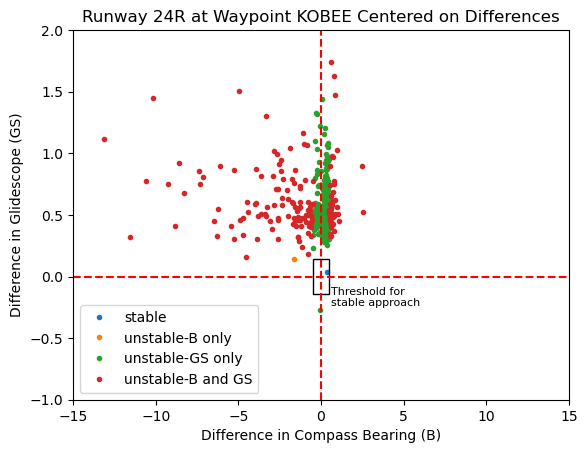

In [90]:
# Centered on the optimal value
fig, ax = plt.subplots()
# x is bearing, y is glidescope
groups = rwy_24r.groupby('stable')
for name, group in groups:
    plt.plot(group['bearing_diff'], group['gs_diff'], marker='o', linestyle='', markersize=3, label=name)

# Add a rectangle to demonstrate the threshold
threshold_x, threshold_y = -0.5, -0.14
ax.add_patch(Rectangle((threshold_x, threshold_y), 1, 0.28, fill=False, zorder=2))
ax.annotate('Threshold for \nstable approach', (abs(threshold_x)+0.1, threshold_y - 0.1), fontsize=8)

# Add lines to indicate where the origin is 
plt.axvline(0, linestyle='--', color='r')
plt.axhline(0, linestyle='--', color='r')

# Add labels and titles
ax.legend(labels= ['stable', 'unstable-B only', 'unstable-GS only', 'unstable-B and GS'], loc='lower left')
ax.set_title('Runway 24R at Waypoint KOBEE Centered on Differences')
ax.set_xlabel('Difference in Compass Bearing (B)')
ax.set_ylabel('Difference in Glidescope (GS)')

# Exclude outliers and center the graph
ax.set_xbound(lower=-15, upper=15)
ax.set_ybound(lower=-1,upper=2)
# Save the plot without outliers
plt.savefig('Sherlock_data/Graphs/Runway24R_nooutlier.jpg')

In [68]:
rwy_24r['b_mean_crt'] = rwy_24r['bearing_diff'] - rwy_24r['bearing_diff'].describe()['mean']
rwy_24r['b_mean_crt'].describe()

/var/folders/62/f84_mp192073x9pd72l46fth0000gn/T/ipykernel_13220/1432974443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rwy_24r['b_mean_crt'] = rwy_24r['bearing_diff'] - rwy_24r['bearing_diff'].describe()['mean']


count    1.906000e+03
mean    -7.262466e-16
std      2.340822e+00
min     -4.166655e+01
25%      2.772671e-01
50%      3.158831e-01
75%      3.383746e-01
max      2.500021e+00
Name: b_mean_crt, dtype: float64

In [69]:
rwy_24r['gs_mean_crt'] = rwy_24r['gs_diff'] - rwy_24r['gs_diff'].describe()['mean']
rwy_24r['gs_mean_crt'].describe()

/var/folders/62/f84_mp192073x9pd72l46fth0000gn/T/ipykernel_13220/475270656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rwy_24r['gs_mean_crt'] = rwy_24r['gs_diff'] - rwy_24r['gs_diff'].describe()['mean']


count    1.906000e+03
mean     1.266330e-15
std      1.476830e-01
min     -7.934875e-01
25%     -5.890085e-02
50%     -1.228622e-02
75%      3.235171e-02
max      1.575470e+00
Name: gs_mean_crt, dtype: float64

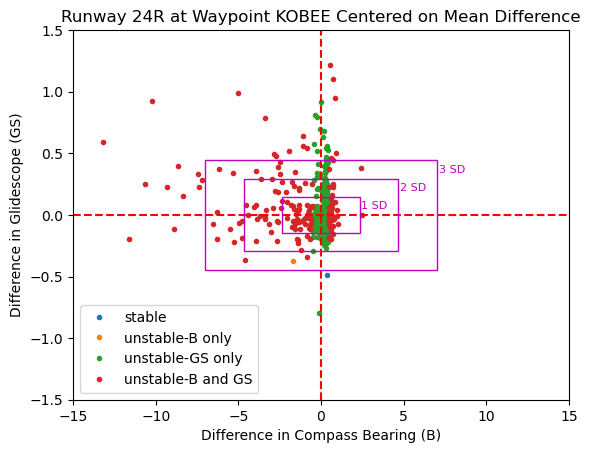

In [89]:
# Center on mean of the differences
fig, ax = plt.subplots()
# x is bearing, y is glidescope
groups = rwy_24r.groupby('stable')
for name, group in groups:
    plt.plot(group['b_mean_crt'], group['gs_mean_crt'], marker='o', linestyle='', markersize=3, label=name)

# Add a rectangle to demonstrate 1SD
std_x, std_y = rwy_24r['bearing_diff'].describe()['std'], rwy_24r['gs_diff'].describe()['std']
ax.add_patch(Rectangle(((-1.0 * std_x), (-1.0 * std_y)), (2*std_x), (2*std_y), fill=False, zorder=3, color='m'))
ax.annotate('1 SD', (abs(std_x)+0.1, abs(std_y) - 0.1), fontsize=8, color='m')

# Add a rectangle to demonstrate 2SD
ax.add_patch(Rectangle(((-2.0 * std_x), (-2.0 * std_y)), (4*std_x), (4*std_y), fill=False, zorder=3, color='m'))
ax.annotate('2 SD', (abs(2.0 *std_x)+0.1, abs(2.0*std_y) - 0.1), fontsize=8, color='m')

# Add a rectangle to demonstrate 3SD
ax.add_patch(Rectangle(((-3.0 * std_x), (-3.0 * std_y)), (6*std_x), (6*std_y), fill=False, zorder=3, color='m'))
ax.annotate('3 SD', (abs(3.0 *std_x)+0.1, abs(3.0*std_y) - 0.1), fontsize=8, color='m')

# Add lines to indicate where the origin is 
plt.axvline(0, linestyle='--', color='r')
plt.axhline(0, linestyle='--', color='r')

# Add labels and titles
ax.legend(labels= ['stable', 'unstable-B only', 'unstable-GS only', 'unstable-B and GS'], loc='lower left')
ax.set_title('Runway 24R at Waypoint KOBEE Centered on Mean Difference')
ax.set_xlabel('Difference in Compass Bearing (B)')
ax.set_ylabel('Difference in Glidescope (GS)')

# Exclude outliers and center the graph
ax.set_xbound(lower=-15, upper=15)
ax.set_ybound(lower=-1.5,upper=1.5)

# Save the plot without outliers
plt.savefig('Sherlock_data/Graphs/Runway24R_meanstd.jpg')

#### For Runway 25L

In [71]:
rwy_25l = good_wp[good_wp['LNDRwy'] == '25L']
rwy_25l

,combo,LNDRwy,alt,Bearing,comp_bearing,ground_dist,glidescope,wp_name,mergeKey,wp_ground_ft,wp_elev,ground_diff,alt_diff,bearing_diff,gs_diff,b_stable,gs_stable,stable
26900,"GIGI,36847_10/01/2022",25L,2075.0,262.7,263.046281,33938.568993,3.498702,GIGI,36847_10/01/2022,33418.66,1900,519.908993,175.0,0.346281,0.498702,0,2,2
26904,"GIGI,36889_10/01/2022",25L,2063.0,262.7,262.932774,33400.917010,3.534371,GIGI,36889_10/01/2022,33418.66,1900,17.742990,163.0,0.232774,0.534371,0,2,2
26905,"GIGI,36894_10/01/2022",25L,2119.0,262.7,263.029932,33711.061514,3.596749,GIGI,36894_10/01/2022,33418.66,1900,292.401514,219.0,0.329932,0.596749,0,2,2
26906,"GIGI,36895_10/01/2022",25L,2081.0,262.7,263.038428,33960.480689,3.506535,GIGI,36895_10/01/2022,33418.66,1900,541.820689,181.0,0.338428,0.506535,0,2,2
26908,"GIGI,36901_10/01/2022",25L,2119.0,262.7,262.982079,33839.545730,3.583128,GIGI,36901_10/01/2022,33418.66,1900,420.885730,219.0,0.282079,0.583128,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30618,"GIGI,87946_05/08/2022",25L,2144.0,262.7,263.117120,33890.797101,3.619822,GIGI,87946_05/08/2022,33418.66,1900,472.137101,244.0,0.417120,0.619822,0,2,2
30621,"GIGI,87963_05/08/2022",25L,2163.0,262.7,263.052408,33788.722860,3.662817,GIGI,87963_05/08/2022,33418.66,1900,370.062860,263.0,0.352408,0.662817,0,2,2
30622,"GIGI,87965_05/08/2022",25L,2119.0,262.7,263.075088,33957.834639,3.570679,GIGI,87965_05/08/2022,33418.66,1900,539.174639,219.0,0.375088,0.570679,0,2,2
30623,"GIGI,87966_05/08/2022",25L,2106.0,262.7,263.084207,33941.934416,3.550488,GIGI,87966_05/08/2022,33418.66,1900,523.274416,206.0,0.384207,0.550488,0,2,2


In [72]:
rwy_25l.groupby('wp_name')['stable'].value_counts()

wp_name  stable
GIGI     2         1280
         3           75
Name: stable, dtype: int64

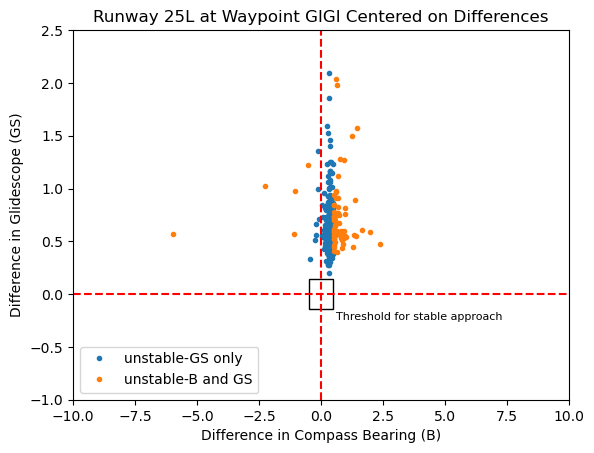

In [91]:
# Center the optimal value
fig, ax = plt.subplots()
# x is bearing, y is glidescope
groups = rwy_25l.groupby('stable')
for name, group in groups:
    plt.plot(group['bearing_diff'], group['gs_diff'], marker='o', linestyle='', markersize=3, label=name)

# Add a rectangle to demonstrate the threshold
threshold_x, threshold_y = -0.5, -0.14
ax.add_patch(Rectangle((threshold_x, threshold_y), 1, 0.28, fill=False, zorder=2))
ax.annotate('Threshold for stable approach', (abs(threshold_x)+0.1, threshold_y-0.1), fontsize=8)

# Add lines to show origin
plt.axvline(0, linestyle='--', color='r')
plt.axhline(0, linestyle='--', color='r')

# Add labels and titles (there are no data for 1: unstable-B only)
ax.legend(labels= ['unstable-GS only', 'unstable-B and GS'], loc='lower left')
ax.set_title('Runway 25L at Waypoint GIGI Centered on Differences')
ax.set_xlabel('Difference in Compass Bearing (B)')
ax.set_ylabel('Difference in Glidescope (GS)')

# Save the plot
# plt.savefig('Sherlock_data/Graphs/Runway25L.png')

# Exclude outliers and center the graph
ax.set_xbound(lower=-10, upper=10)
ax.set_ybound(lower=-1,upper=2.5)
# Save the plot without outliers
plt.savefig('Sherlock_data/Graphs/Runway25L_nooutlier.jpg')

In [74]:
rwy_25l['b_mean_crt'] = rwy_25l['bearing_diff'] - rwy_25l['bearing_diff'].describe()['mean']
rwy_25l['b_mean_crt'].describe()

/var/folders/62/f84_mp192073x9pd72l46fth0000gn/T/ipykernel_13220/415100505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rwy_25l['b_mean_crt'] = rwy_25l['bearing_diff'] - rwy_25l['bearing_diff'].describe()['mean']


count    1.355000e+03
mean    -3.572378e-16
std      5.184689e-01
min     -1.687278e+01
25%     -2.269061e-02
50%      4.242568e-03
75%      4.200432e-02
max      2.031351e+00
Name: b_mean_crt, dtype: float64

In [75]:
rwy_25l['gs_mean_crt'] = rwy_25l['gs_diff'] - rwy_25l['gs_diff'].describe()['mean']
rwy_25l['gs_mean_crt'].describe()

/var/folders/62/f84_mp192073x9pd72l46fth0000gn/T/ipykernel_13220/1583925436.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rwy_25l['gs_mean_crt'] = rwy_25l['gs_diff'] - rwy_25l['gs_diff'].describe()['mean']


count    1.355000e+03
mean     5.374954e-17
std      1.563311e-01
min     -3.847218e-01
25%     -6.899249e-02
50%     -1.926770e-02
75%      3.419584e-02
max      1.503655e+00
Name: gs_mean_crt, dtype: float64

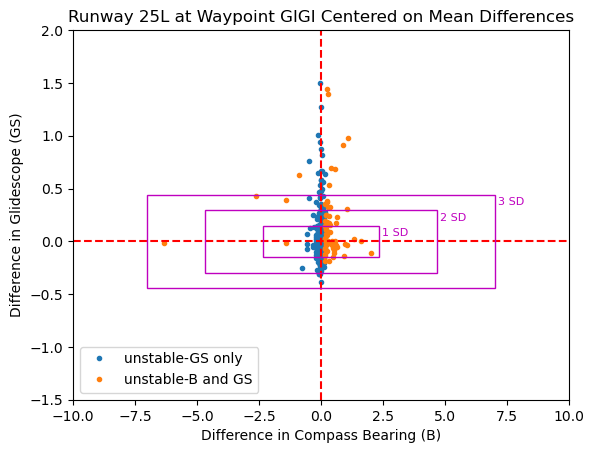

In [92]:
# Center the graph on mean differences
fig, ax = plt.subplots()
# x is bearing, y is glidescope
groups = rwy_25l.groupby('stable')
for name, group in groups:
    plt.plot(group['b_mean_crt'], group['gs_mean_crt'], marker='o', linestyle='', markersize=3, label=name)

# Add a rectangle to demonstrate 1SD
std_x, std_y = rwy_24r['bearing_diff'].describe()['std'], rwy_24r['gs_diff'].describe()['std']
ax.add_patch(Rectangle(((-1.0 * std_x), (-1.0 * std_y)), (2*std_x), (2*std_y), fill=False, zorder=3, color='m'))
ax.annotate('1 SD', (abs(std_x)+0.1, abs(std_y) - 0.1), fontsize=8, color='m')

# Add a rectangle to demonstrate 2SD
ax.add_patch(Rectangle(((-2.0 * std_x), (-2.0 * std_y)), (4*std_x), (4*std_y), fill=False, zorder=3, color='m'))
ax.annotate('2 SD', (abs(2.0 *std_x)+0.1, abs(2.0*std_y) - 0.1), fontsize=8, color='m')

# Add a rectangle to demonstrate 3SD
ax.add_patch(Rectangle(((-3.0 * std_x), (-3.0 * std_y)), (6*std_x), (6*std_y), fill=False, zorder=3, color='m'))
ax.annotate('3 SD', (abs(3.0 *std_x)+0.1, abs(3.0*std_y) - 0.1), fontsize=8, color='m')

# Add lines to show origin
plt.axvline(0, linestyle='--', color='r')
plt.axhline(0, linestyle='--', color='r')

# Add labels and titles
ax.legend(labels= ['unstable-GS only', 'unstable-B and GS'], loc='lower left')
ax.set_title('Runway 25L at Waypoint GIGI Centered on Mean Differences')
ax.set_xlabel('Difference in Compass Bearing (B)')
ax.set_ylabel('Difference in Glidescope (GS)')

# Exclude outliers and center the graph
ax.set_xbound(lower=-10, upper=10)
ax.set_ybound(lower=-1.5,upper=2)
# Save the plot
plt.savefig('Sherlock_data/Graphs/Runway25L_meanstd.jpg')